In [ ]:
!pip install geopandas contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 68.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import geopandas as gpd
import contextily as ctx

In [ ]:
df = pd.read_csv('/OMDB.csv')
df.head()

<ipython-input-4-60cd7b1eb009>:1: DtypeWarning: Columns (5,6,7,9,10,11,13,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/OMDB.csv')


,station,valid,lon,lat,elevation,tmpf,dwpf,relh,drct,sknt,...,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,OMDB,01/01/2000 00:00,55.3656,25.2539,5,59,55.76,88.98,180,2,...,M,M,M,M,M,M,M,59,OMDB 010000Z AUTO 18002KT 4SM 15/13 A2994 RMK ...,M
1,OMDB,01/01/2000 01:00,55.3656,25.2539,5,59,55.4,87.83,190,2,...,M,M,M,M,M,M,M,59,OMDB 010100Z AUTO 19002KT 3SM 15/13 A2994 RMK ...,M
2,OMDB,01/01/2000 02:00,55.3656,25.2539,5,59,55.4,87.83,180,2,...,M,M,M,M,M,M,M,59,OMDB 010200Z AUTO 18002KT 2SM 15/13 A2994 RMK ...,M
3,OMDB,01/01/2000 03:00,55.3656,25.2539,5,56.48,54,91.24,190,2,...,M,M,M,M,M,M,M,56.48,OMDB 010300Z AUTO 19002KT 2SM 14/12 A2997 RMK ...,M
4,OMDB,01/01/2000 04:00,55.3656,25.2539,5,57.2,55.4,93.69,190,1,...,M,M,M,M,M,M,M,57.2,OMDB 010400Z AUTO 19001KT 1 1/4SM 14/13 A3000 ...,M


In [ ]:
df.shape

(234486, 33)

**Preprocessing**

In [ ]:
df.isna().sum()

station              0
valid                0
lon                  0
lat                  0
elevation            0
tmpf                 0
dwpf                 0
relh                 0
drct                 0
sknt                 0
p01i                 0
alti                 0
mslp                 0
vsby                 0
gust                 0
skyc1                0
skyc2                0
skyc3                0
skyc4                0
skyl1                0
skyl2                0
skyl3                0
skyl4                0
wxcodes              2
ice_accretion_1hr    0
ice_accretion_3hr    0
ice_accretion_6hr    0
peak_wind_gust       0
peak_wind_drct       0
peak_wind_time       0
feel                 0
metar                0
snowdepth            0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234486 entries, 0 to 234485
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   station            234486 non-null  object 
 1   valid              234486 non-null  object 
 2   lon                234486 non-null  float64
 3   lat                234486 non-null  float64
 4   elevation          234486 non-null  int64  
 5   tmpf               234486 non-null  object 
 6   dwpf               234486 non-null  object 
 7   relh               234486 non-null  object 
 8   drct               234486 non-null  object 
 9   sknt               234486 non-null  object 
 10  p01i               234486 non-null  object 
 11  alti               234486 non-null  object 
 12  mslp               234486 non-null  object 
 13  vsby               234486 non-null  object 
 14  gust               234486 non-null  object 
 15  skyc1              234486 non-null  object 
 16  sk

In [ ]:
# Identify columns with "M" values
columns_with_M = df.columns[df.isin(['M']).any()]
print("Columns with 'M' values:", columns_with_M)

# Count the number of "M" values in each identified column
for column in columns_with_M:
    count_M = df[column].value_counts().get('M', 0)
    print(f"Column {column} has {count_M} 'M' values")

Columns with 'M' values: Index(['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby',
       'gust', 'skyc1', 'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3',
       'skyl4', 'wxcodes', 'ice_accretion_1hr', 'ice_accretion_3hr',
       'ice_accretion_6hr', 'peak_wind_gust', 'peak_wind_drct',
       'peak_wind_time', 'feel', 'snowdepth'],
      dtype='object')
Column tmpf has 442 'M' values
Column dwpf has 604 'M' values
Column relh has 651 'M' values
Column drct has 20639 'M' values
Column sknt has 4990 'M' values
Column p01i has 53491 'M' values
Column alti has 2069 'M' values
Column mslp has 221318 'M' values
Column vsby has 1012 'M' values
Column gust has 233141 'M' values
Column skyc1 has 166011 'M' values
Column skyc2 has 228481 'M' values
Column skyc3 has 230571 'M' values
Column skyc4 has 230741 'M' values
Column skyl1 has 207974 'M' values
Column skyl2 has 232215 'M' values
Column skyl3 has 234316 'M' values
Column skyl4 has 234485 'M' values
Column wxcode

In [ ]:
# Dropping columns with more than 2 lakh missing entries
columns_to_drop = ['gust', 'p01i', 'skyl2', 'skyl3', 'skyl4', 'wxcodes', 'ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr',
                   'peak_wind_gust', 'peak_wind_drct', 'peak_wind_time', 'snowdepth']
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Identify columns with "M" values after dropping
columns_with_M = df.columns[df.isin(['M']).any()]
print("Columns with 'M' values after dropping:", columns_with_M)

# Count the number of "M" values in each identified column after dropping
for column in columns_with_M:
    count_M = df[column].value_counts().get('M', 0)
    print(f"Column {column} has {count_M} 'M' values")

Columns with 'M' values after dropping: Index(['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'mslp', 'vsby', 'skyc1',
       'skyc2', 'skyc3', 'skyc4', 'skyl1', 'feel'],
      dtype='object')
Column tmpf has 442 'M' values
Column dwpf has 604 'M' values
Column relh has 651 'M' values
Column drct has 20639 'M' values
Column sknt has 4990 'M' values
Column alti has 2069 'M' values
Column mslp has 221318 'M' values
Column vsby has 1012 'M' values
Column skyc1 has 166011 'M' values
Column skyc2 has 228481 'M' values
Column skyc3 has 230571 'M' values
Column skyc4 has 230741 'M' values
Column skyl1 has 207974 'M' values
Column feel has 665 'M' values


In [ ]:
# Convert 'M' to NaN and then calculate mean for numeric columns
for column in columns_with_M:
    if column in ["tmpf", "dwpf", "alti", "drct", "sknt", "relh", "mslp", "vsby", "skyl1", "feel"]:
        df[column] = pd.to_numeric(df[column], errors='coerce')
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)

In [ ]:
df.head()

,station,valid,lon,lat,elevation,tmpf,dwpf,relh,drct,sknt,alti,mslp,vsby,skyc1,skyc2,skyc3,skyc4,skyl1,feel,metar
0,OMDB,01/01/2000 00:00,55.3656,25.2539,5,59.00,55.76,88.98,180.0,2.0,29.94,1014.800000,4.00,M,M,M,M,4138.454285,59.00,OMDB 010000Z AUTO 18002KT 4SM 15/13 A2994 RMK ...
1,OMDB,01/01/2000 01:00,55.3656,25.2539,5,59.00,55.40,87.83,190.0,2.0,29.94,1008.421826,3.00,M,M,M,M,4138.454285,59.00,OMDB 010100Z AUTO 19002KT 3SM 15/13 A2994 RMK ...
2,OMDB,01/01/2000 02:00,55.3656,25.2539,5,59.00,55.40,87.83,180.0,2.0,29.94,1008.421826,2.00,M,M,M,M,4138.454285,59.00,OMDB 010200Z AUTO 18002KT 2SM 15/13 A2994 RMK ...
3,OMDB,01/01/2000 03:00,55.3656,25.2539,5,56.48,54.00,91.24,190.0,2.0,29.97,1015.700000,2.00,M,M,M,M,4138.454285,56.48,OMDB 010300Z AUTO 19002KT 2SM 14/12 A2997 RMK ...
4,OMDB,01/01/2000 04:00,55.3656,25.2539,5,57.20,55.40,93.69,190.0,1.0,30.00,1008.421826,1.25,M,M,M,M,4138.454285,57.20,OMDB 010400Z AUTO 19001KT 1 1/4SM 14/13 A3000 ...


In [ ]:
# Convert 'valid' column to datetime, handling different date formats
df['valid'] = pd.to_datetime(df['valid'], errors='coerce', dayfirst=True)

# Convert relevant columns to numeric, forcing errors to NaN
cols = ['tmpf', 'dwpf', 'relh', 'sknt']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Define heat wave conditions
temperature_threshold = 95  # Define the temperature threshold for a heatwave
humidity_threshold = 60     # Define the relative humidity threshold for a heatwave
wind_speed_threshold = 10   # Define the wind speed threshold for a heatwave
consecutive_hours = 3       # Define the number of consecutive hours to be considered a heatwave

# Initialize heatwave index column with 0
df['heatwave_index'] = 0.0

# Loop through the data and calculate the heatwave index
for i in range(len(df) - consecutive_hours + 1):
    temp_excess = df['tmpf'][i:i + consecutive_hours] - temperature_threshold
    relh_excess = df['relh'][i:i + consecutive_hours] - humidity_threshold
    wind_deficit = wind_speed_threshold - df['sknt'][i:i + consecutive_hours]

    # Only consider positive excesses and deficits
    temp_excess[temp_excess < 0] = 0
    relh_excess[relh_excess < 0] = 0
    wind_deficit[wind_deficit < 0] = 0

    heatwave_intensity = temp_excess + relh_excess + wind_deficit

    # Sum the heatwave intensity over the consecutive hours
    df.loc[i:i + consecutive_hours - 1, 'heatwave_index'] += heatwave_intensity.sum()

# Display the dataframe with the new heatwave index feature
print(df.head())

  station               valid      lon      lat  elevation   tmpf   dwpf  \
0    OMDB 2000-01-01 00:00:00  55.3656  25.2539          5  59.00  55.76   
1    OMDB 2000-01-01 01:00:00  55.3656  25.2539          5  59.00  55.40   
2    OMDB 2000-01-01 02:00:00  55.3656  25.2539          5  59.00  55.40   
3    OMDB 2000-01-01 03:00:00  55.3656  25.2539          5  56.48  54.00   
4    OMDB 2000-01-01 04:00:00  55.3656  25.2539          5  57.20  55.40   

    relh   drct  sknt  ...         mslp  vsby  skyc1 skyc2 skyc3 skyc4  \
0  88.98  180.0   2.0  ...  1014.800000  4.00      M     M     M     M   
1  87.83  190.0   2.0  ...  1008.421826  3.00      M     M     M     M   
2  87.83  180.0   2.0  ...  1008.421826  2.00      M     M     M     M   
3  91.24  190.0   2.0  ...  1015.700000  2.00      M     M     M     M   
4  93.69  190.0   1.0  ...  1008.421826  1.25      M     M     M     M   

         skyl1   feel                                              metar  \
0  4138.454285  59.00 

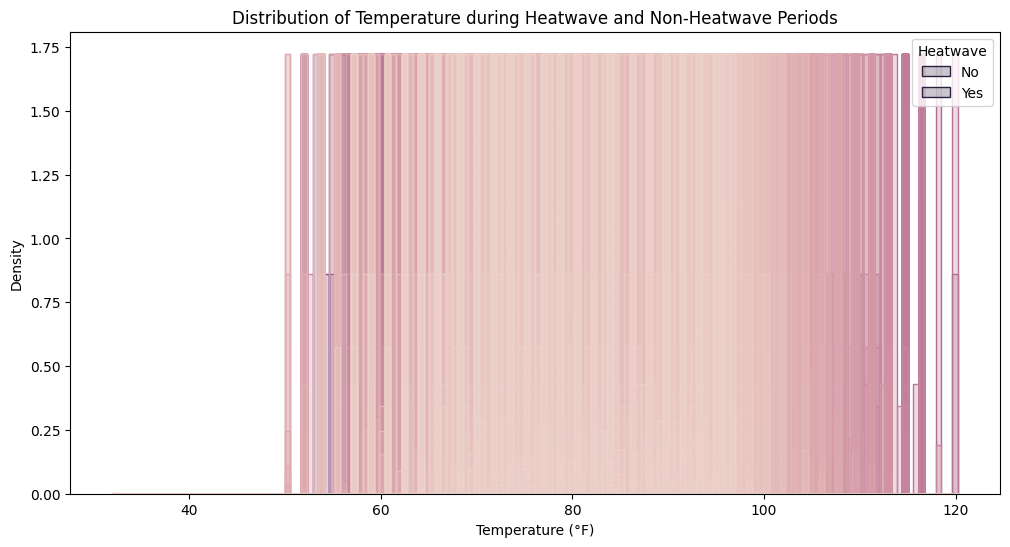

In [ ]:
# Plot histogram of temperature for heatwave and non-heatwave periods
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='tmpf', hue='heatwave_index', element='step', stat='density', common_norm=False)
plt.title('Distribution of Temperature during Heatwave and Non-Heatwave Periods')
plt.xlabel('Temperature (°F)')
plt.ylabel('Density')
plt.legend(title='Heatwave', labels=['No', 'Yes'])
plt.show()

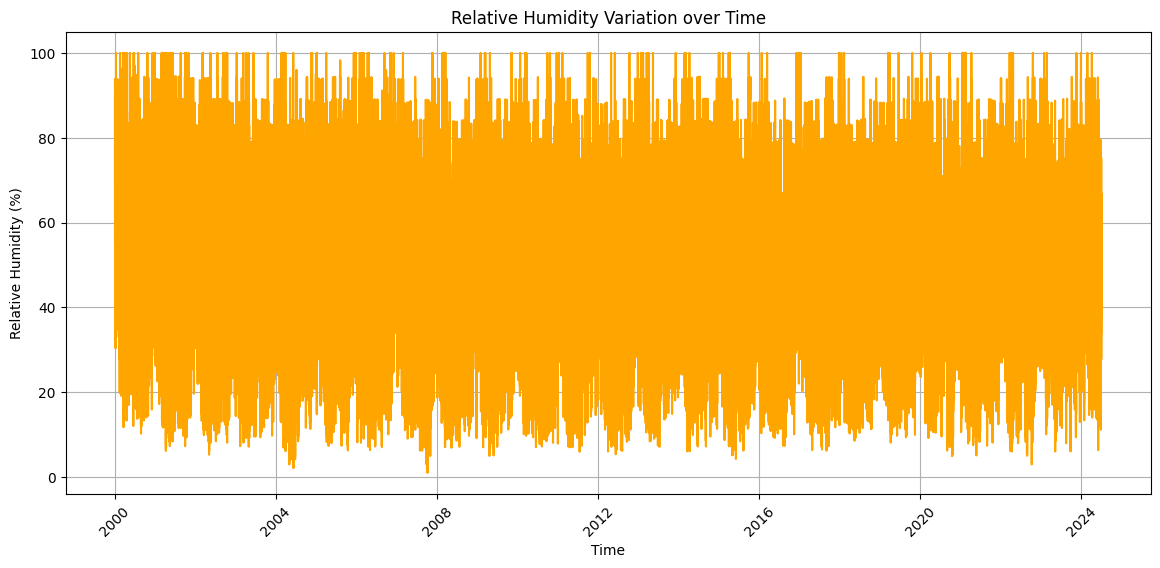

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['valid'], df['relh'], color='orange')
plt.title('Relative Humidity Variation over Time')
plt.xlabel('Time')
plt.ylabel('Relative Humidity (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

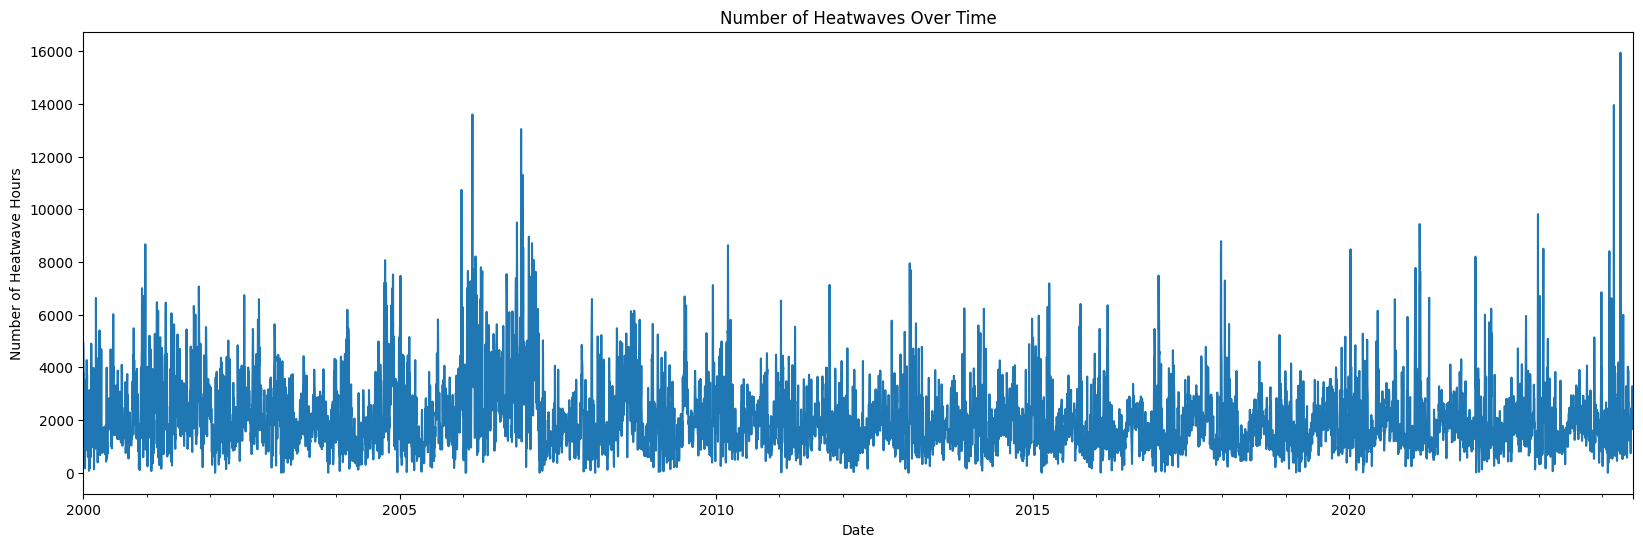

In [ ]:
# Plot time series of heatwaves
plt.figure(figsize=(20, 6))
heatwave_counts = df.set_index('valid').resample('D')['heatwave_index'].sum()
heatwave_counts.plot()
plt.title('Number of Heatwaves Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Heatwave Hours')
plt.show()

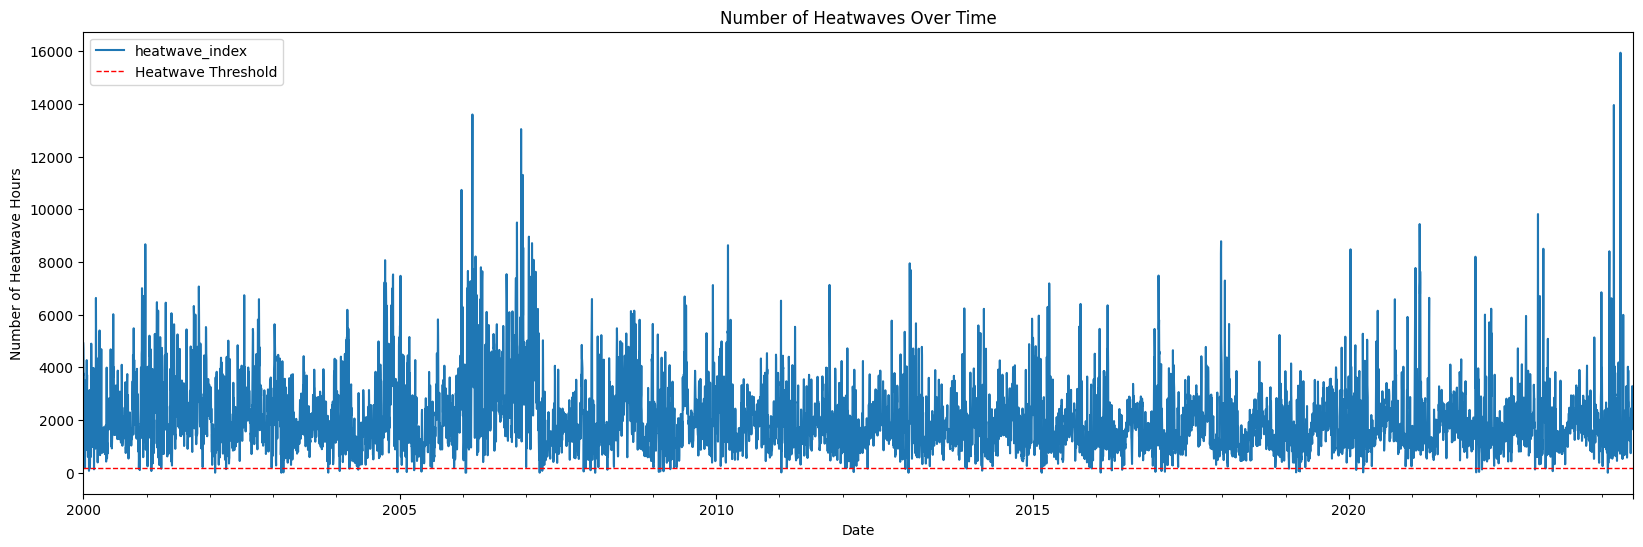

Calculated Heatwave Threshold (90th percentile): 183.0


In [ ]:
# Plot time series of heatwaves
plt.figure(figsize=(20, 6))
heatwave_counts = df.set_index('valid').resample('D')['heatwave_index'].sum()
ax = heatwave_counts.plot()

# Add a horizontal dotted line to differentiate the heatwave scale
heatwave_threshold = np.percentile(df['heatwave_index'], 90)
ax.axhline(heatwave_threshold, color='red', linestyle='--', linewidth=1, label='Heatwave Threshold')

plt.title('Number of Heatwaves Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Heatwave Hours')
plt.legend()
plt.show()

# Print the calculated heatwave threshold
print(f'Calculated Heatwave Threshold (90th percentile): {heatwave_threshold}')

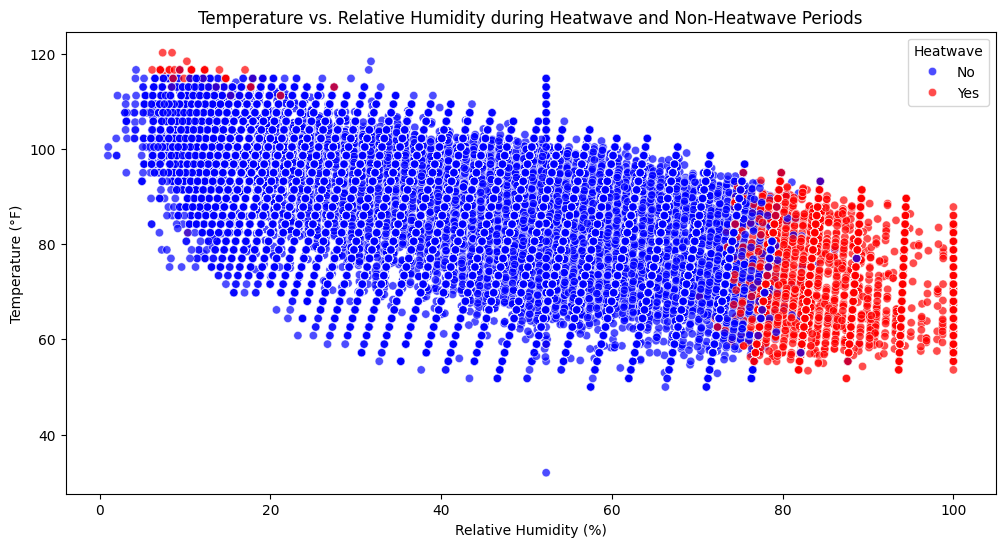

Calculated Heatwave Threshold (90th percentile): 183.0


In [ ]:
# Determine if it is a heatwave based on a threshold
heatwave_threshold = np.percentile(df['heatwave_index'], 90)
df['is_heatwave'] = df['heatwave_index'] > heatwave_threshold

# Define a custom color palette
custom_palette = {True: "red", False: "blue"}

# Scatter plot of temperature vs. relative humidity, colored by heatwave
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='relh', y='tmpf', hue='is_heatwave', palette=custom_palette, alpha=0.7)
plt.title('Temperature vs. Relative Humidity during Heatwave and Non-Heatwave Periods')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Temperature (°F)')
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['No', 'Yes']
plt.legend(handles=handles, labels=labels, title='Heatwave')
plt.show()

# Print the calculated heatwave threshold
print(f'Calculated Heatwave Threshold (90th percentile): {heatwave_threshold}')

Heatwave periods, represented by the red points in the scatter plot, typically exhibit higher temperatures, concentrated around and above 100°F. These periods can occur under both low and high relative humidity conditions, indicating that heatwaves are primarily associated with high temperatures, regardless of whether the air is dry or humid. In contrast, non-heatwave periods, shown as blue points, span a broader range of temperatures and relative humidity levels. These periods are mostly found below the 100°F mark, reflecting more moderate temperature conditions.

<ipython-input-17-ade14b0a0939>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', pad=0.02)


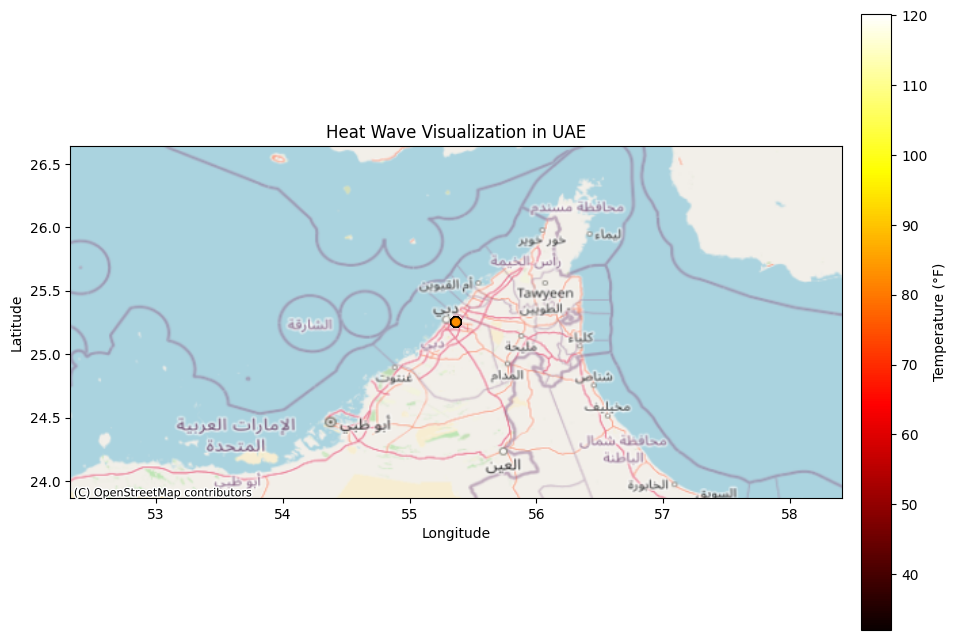

In [ ]:
df_sample = df.sample(234486)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_sample, geometry=gpd.points_from_xy(df_sample.lon, df_sample.lat))

# Assign a CRS to the GeoDataFrame
gdf.set_crs(epsg=4326, inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the points with colors based on temperature
norm = plt.Normalize(vmin=gdf['tmpf'].min(), vmax=gdf['tmpf'].max())
colors = plt.cm.hot(norm(gdf['tmpf']))

gdf.plot(ax=ax, color=colors, edgecolor='k', markersize=50, alpha=0.7)

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap='hot', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', pad=0.02)
cbar.set_label('Temperature (°F)')

# Add titles and labels
plt.title('Heat Wave Visualization in UAE')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

<ipython-input-18-9e1cd00b6fda>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='month', y='relh', data=df, ci=None, palette='viridis')
<ipython-input-18-9e1cd00b6fda>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='relh', data=df, ci=None, palette='viridis')


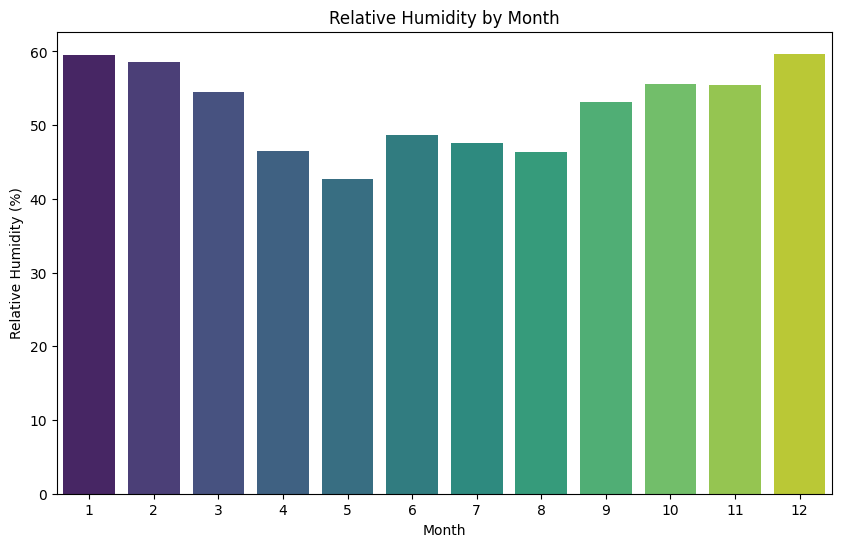

In [ ]:
# Convert 'valid' column to datetime format
df['valid'] = pd.to_datetime(df['valid'], format='%d/%m/%Y %H:%M')

df['month'] = df['valid'].dt.month

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='relh', data=df, ci=None, palette='viridis')
plt.title('Relative Humidity by Month')
plt.xlabel('Month')
plt.ylabel('Relative Humidity (%)')
plt.show()

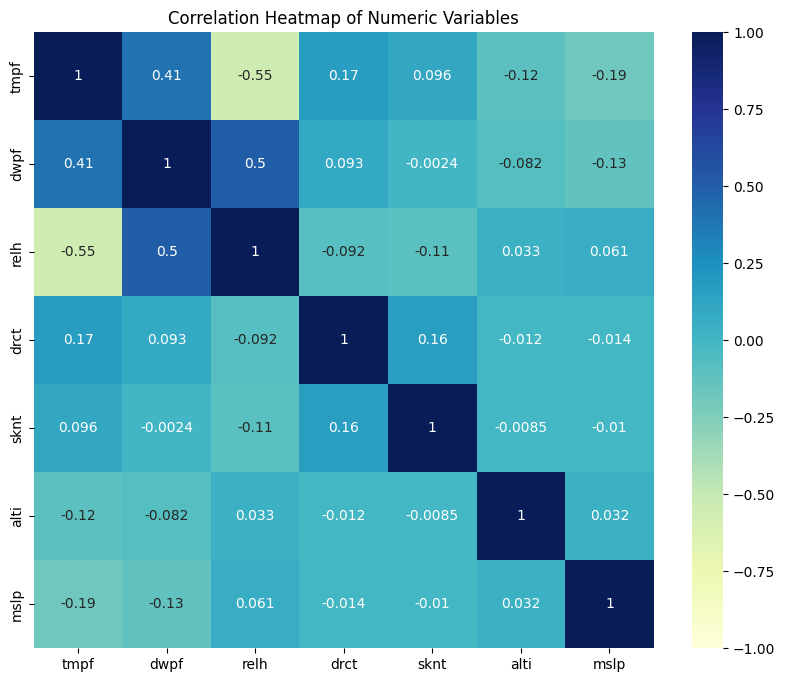

In [ ]:
numeric_vars = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'mslp']
corr = df[numeric_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='YlGnBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

In [ ]:
encoder = LabelEncoder()

# Encode each column
df['skyc1'] = encoder.fit_transform(df['skyc1'])
df['skyc2'] = encoder.fit_transform(df['skyc2'])
df['skyc3'] = encoder.fit_transform(df['skyc3'])
df['skyc4'] = encoder.fit_transform(df['skyc4'])
df['metar'] = encoder.fit_transform(df['metar'])

**Feature Engineering**

In [ ]:
# Convert 'valid' column to datetime format
df['valid'] = pd.to_datetime(df['valid'], format='%d/%m/%Y %H:%M')

In [ ]:
# Extract features from 'valid' column
df['year'] = df['valid'].dt.year
df['month'] = df['valid'].dt.month
df['day'] = df['valid'].dt.day
df['hour'] = df['valid'].dt.hour
df['minutes'] = df['valid'].dt.minute
df['weekday'] = df['valid'].dt.weekday  # Monday is 0 and Sunday is 6

In [ ]:
# Dropping unnecessay colums
df.drop(columns=['valid'], inplace=True)
df.drop(columns=['station'], inplace=True)

In [ ]:
df.head()

,lon,lat,elevation,tmpf,dwpf,relh,drct,sknt,alti,mslp,...,metar,heatwave,heatwave_index,is_heatwave,month,year,day,hour,minutes,weekday
0,55.3656,25.2539,5,59.00,55.76,88.98,180.0,2.0,29.94,1014.800000,...,359,0,108.640000,True,1,2000,1,0,0,5
1,55.3656,25.2539,5,59.00,55.40,87.83,190.0,2.0,29.94,1008.421826,...,693,0,219.540000,True,1,2000,1,1,0,5
2,55.3656,25.2539,5,59.00,55.40,87.83,180.0,2.0,29.94,1008.421826,...,1010,0,337.300000,True,1,2000,1,2,0,5
3,55.3656,25.2539,5,56.48,54.00,91.24,190.0,2.0,29.97,1015.700000,...,1348,0,345.510000,True,1,2000,1,3,0,5
4,55.3656,25.2539,5,57.20,55.40,93.69,190.0,1.0,30.00,1008.421826,...,1673,0,335.121776,True,1,2000,1,4,0,5


In [ ]:
df.shape

(234486, 27)

**Dataset Splitting**

In [ ]:
# Define features and target
X = df.drop(columns=['heatwave_index'])
y = df['heatwave_index']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model Building**

In [ ]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

In [ ]:
# Dataframe to store the results
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2 Score'])

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    new_row = pd.DataFrame({'Model': [name], 'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae], 'R2 Score': [r2]})
    results = pd.concat([results, new_row], ignore_index=True)

    print(f"Results for {name}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2 Score: {r2:.2f}")
    print("-----------------------------")

Results for Linear Regression:
  MSE: 890.10
  MAE: 23.29
  RMSE: 29.83
  R2 Score: 0.83
-----------------------------
Results for Decision Tree:
  MSE: 296.35
  MAE: 11.81
  RMSE: 17.21
  R2 Score: 0.94
-----------------------------
Results for Random Forest:
  MSE: 151.00
  MAE: 8.53
  RMSE: 12.29
  R2 Score: 0.97
-----------------------------
Results for Gradient Boosting:
  MSE: 172.66
  MAE: 9.40
  RMSE: 13.14
  R2 Score: 0.97
-----------------------------


<ipython-input-29-a568e47052be>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MSE', data=results, palette=colors)


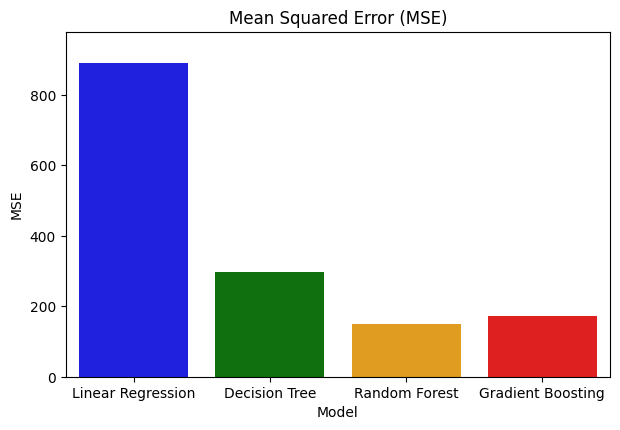

In [ ]:
# Define custom colors for each model
colors = {'Linear Regression': 'blue',
          'Decision Tree': 'green',
          'Random Forest': 'orange',
          'Gradient Boosting': 'red'}

# Plotting the results one by one
plt.figure(figsize=(12, 8))

# MSE Plot
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='MSE', data=results, palette=colors)
plt.title('Mean Squared Error (MSE)')
plt.ylim(0, max(results['MSE']) * 1.1)
plt.tight_layout()
plt.show()

<ipython-input-30-d8098ba73e2f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results, palette=colors)


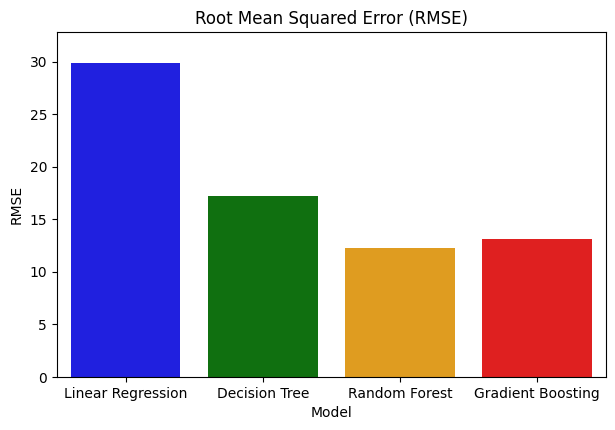

In [ ]:
# RMSE Plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='RMSE', data=results, palette=colors)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylim(0, max(results['RMSE']) * 1.1)
plt.tight_layout()
plt.show()

<ipython-input-31-89f2ffc70547>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results, palette=colors)


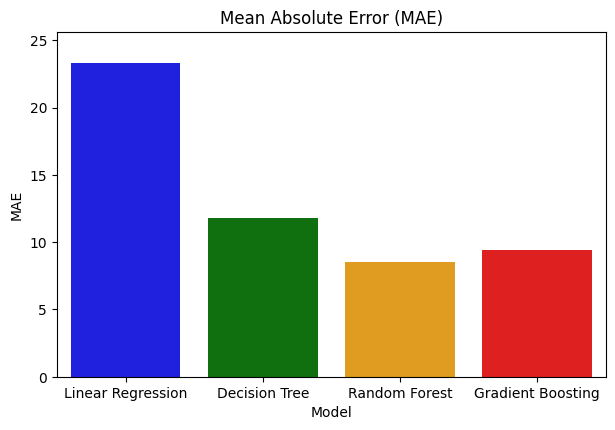

In [ ]:
# MAE Plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='MAE', data=results, palette=colors)
plt.title('Mean Absolute Error (MAE)')
plt.ylim(0, max(results['MAE']) * 1.1)
plt.tight_layout()
plt.show()

<ipython-input-32-c371e916d673>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=results, palette=colors)


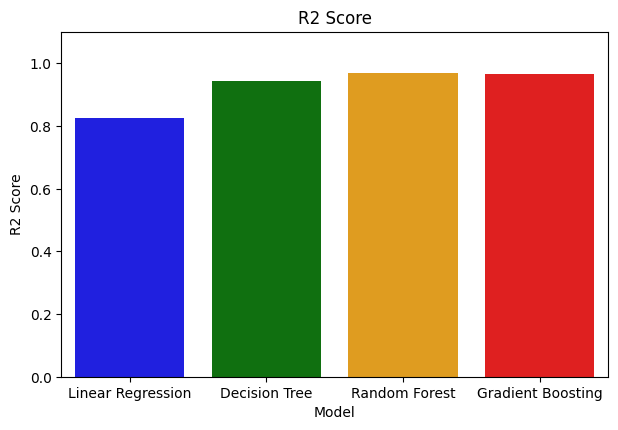

In [ ]:
# R2 Score Plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='R2 Score', data=results, palette=colors)
plt.title('R2 Score')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()